<a href="https://colab.research.google.com/github/adammoss/bnn_hmc/blob/main/results/MLSST_MCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import os
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
samples_iter = 200
dropout = 0.1

In [3]:
!pip install astro-datasets --upgrade
!pip install tensorflow_datasets --upgrade
import astro_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
ds_train_Y10, info_train_Y10 = tfds.load(name='mlsst/Y10', split='train', with_info=True, as_supervised=True, batch_size=50)
ds_valid_Y10, info_valid_Y10 = tfds.load(name='mlsst/Y10', split='validation', with_info=True, as_supervised=True, batch_size=50)
ds_test_Y10, info_test_Y10 = tfds.load(name='mlsst/Y10', split='test', with_info=True, as_supervised=True, batch_size=50)

In [5]:
def normalize(image, label):  
  image = tf.math.asinh(image)
  return image, label

ds_train_Y10 = ds_train_Y10.map(normalize)
ds_valid_Y10 = ds_valid_Y10.map(normalize)
ds_test_Y10 = ds_test_Y10.map(normalize)

In [6]:
class MonteCarloDropout(tf.keras.layers.Dropout):
     def call(self, inputs):
         return super().call(inputs, training=True)

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=5, strides=1, padding = 'same', input_shape=(100, 100, 3)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2,2)),
    MonteCarloDropout(dropout),
    tf.keras.layers.Conv2D(16, kernel_size=5, strides=1, padding = 'same'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2,2)),
    MonteCarloDropout(dropout),
    tf.keras.layers.Conv2D(120, kernel_size=5, strides=1, padding = 'same'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2,2)),
    MonteCarloDropout(dropout),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(84),
    tf.keras.layers.ReLU(),
    MonteCarloDropout(dropout),
    tf.keras.layers.Dense(3, activation='softmax'),
    ])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 6)       456       
                                                                 
 re_lu (ReLU)                (None, 100, 100, 6)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 6)        0         
 )                                                               
                                                                 
 monte_carlo_dropout (MonteC  (None, 49, 49, 6)        0         
 arloDropout)                                                    
                                                                 
 conv2d_1 (Conv2D)           (None, 49, 49, 16)        2416      
                                                                 
 re_lu_1 (ReLU)              (None, 49, 49, 16)        0

In [9]:
loss=tf.keras.losses.SparseCategoricalCrossentropy()

In [10]:
opt = tf.keras.optimizers.Adam(learning_rate=5e-5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=3)

In [11]:
model.compile(optimizer=opt,
              loss=loss,
              metrics='accuracy')

In [12]:
checkpoint_path = "mlsst/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=False,
                                                  monitor='val_loss',
                                                  mode='min',
                                                  verbose=1,
                                                  save_best_only=True)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [13]:
model.fit(ds_train_Y10, epochs=100, callbacks=[reduce_lr, cp_callback, es_callback], validation_data=ds_valid_Y10)

Epoch 1/100
470/470 [==============================] - ETA: 0s - loss: 1.1197 - accuracy: 0.4776
Epoch 1: val_loss improved from inf to 0.96703, saving model to mlsst/cp.ckpt
470/470 [==============================] - 12s 18ms/step - loss: 1.1197 - accuracy: 0.4776 - val_loss: 0.9670 - val_accuracy: 0.5159 - lr: 5.0000e-05
Epoch 2/100
465/470 [============================>.] - ETA: 0s - loss: 0.9499 - accuracy: 0.5390
Epoch 2: val_loss improved from 0.96703 to 0.93351, saving model to mlsst/cp.ckpt
470/470 [==============================] - 8s 16ms/step - loss: 0.9502 - accuracy: 0.5387 - val_loss: 0.9335 - val_accuracy: 0.5618 - lr: 5.0000e-05
Epoch 3/100
468/470 [============================>.] - ETA: 0s - loss: 0.9344 - accuracy: 0.5497
Epoch 3: val_loss improved from 0.93351 to 0.91620, saving model to mlsst/cp.ckpt
470/470 [==============================] - 8s 16ms/step - loss: 0.9350 - accuracy: 0.5498 - val_loss: 0.9162 - val_accuracy: 0.5690 - lr: 5.0000e-05
Epoch 4/100
466/470

In [21]:
new_model = tf.keras.models.load_model('mlsst/cp.ckpt')

In [23]:
softmax = []
accuracies = []
for _ in range(samples_iter):
  y = []
  yhat = []
  logits = []
  for (x_batch, y_batch) in ds_test_Y10:
      s = new_model.predict(x_batch)
      yhat.append(np.argmax(s, axis=-1))
      y.append(y_batch)
      logits.append(s)
  y = np.concatenate(y)
  yhat = np.concatenate(yhat)
  softmax.append(np.concatenate(logits))
  accuracies.append(np.mean(yhat == y))
  print('Accuracy:', np.mean(yhat == y))
softmax = np.array(softmax)

Accuracy: 0.6302308265078184
Accuracy: 0.6308265078183172
Accuracy: 0.6297840655249441
Accuracy: 0.6312732688011914
Accuracy: 0.6290394638868205
Accuracy: 0.6375279225614296
Accuracy: 0.6275502606105734
Accuracy: 0.6305286671630678
Accuracy: 0.6269545793000745
Accuracy: 0.6296351451973194
Accuracy: 0.6303797468354431
Accuracy: 0.6361876396128071
Accuracy: 0.6324646314221891
Accuracy: 0.6302308265078184
Accuracy: 0.62933730454207
Accuracy: 0.63469843633656
Accuracy: 0.6287416232315711
Accuracy: 0.6198064035740879
Accuracy: 0.6326135517498138
Accuracy: 0.637825763216679
Accuracy: 0.6323157110945644
Accuracy: 0.6248696947133283
Accuracy: 0.6294862248696947
Accuracy: 0.632017870439315
Accuracy: 0.6291883842144452
Accuracy: 0.6349962769918094
Accuracy: 0.6315711094564408
Accuracy: 0.6321667907669397
Accuracy: 0.6279970215934475
Accuracy: 0.6333581533879374
Accuracy: 0.6305286671630678
Accuracy: 0.6265078183172003
Accuracy: 0.6288905435591958
Accuracy: 0.6279970215934475
Accuracy: 0.62159344

In [24]:
print('Accuracy', np.mean(accuracies), np.std(accuracies))

Accuracy 0.6310625465376024 0.003960000618947224


In [25]:
def uncertainty(softmax):
  # Per example softmax with shape(num_examples, num_classes)
  predictive_entropy = 0
  single_pass_entropy = 0
  for i in range(softmax.shape[1]):
    # Sum over classes
    predictive_entropy += -np.mean(softmax[:,i])*np.log(np.mean(softmax[:,i]))
    single_pass_entropy += -softmax[:,i]*np.log(softmax[:,i])
  single_pass_entropy = np.mean(single_pass_entropy)
  mutual_info = predictive_entropy - single_pass_entropy
  return predictive_entropy, single_pass_entropy, mutual_info

In [26]:
predictive_entropies = [] 
single_pass_entropies = []
mutual_infos = []
for i in range(softmax.shape[1]):
  predictive_entropy, single_pass_entropy, mutual_info = uncertainty(softmax[:,i,:])
  predictive_entropies.append(predictive_entropy)
  single_pass_entropies.append(single_pass_entropy)
  mutual_infos.append(mutual_info)
print('Predictive entropy:', np.mean(predictive_entropies), np.std(predictive_entropies))
print('Single pass entropy:', np.mean(single_pass_entropies), np.std(single_pass_entropies))
print('Mutual info:', np.mean(mutual_infos), np.std(mutual_infos))

Predictive entropy: 0.7548963319361538 0.30381212725454704
Single pass entropy: 0.6599981 0.3030059
Mutual info: 0.09489820944773557 0.04021800700096953


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


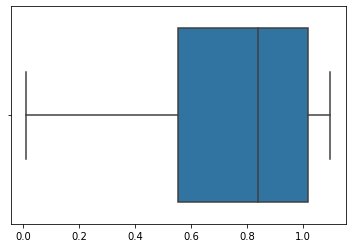

In [27]:
sns.boxplot(predictive_entropies)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


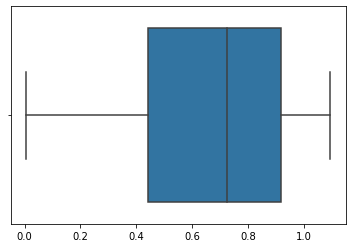

In [28]:
sns.boxplot(single_pass_entropies)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


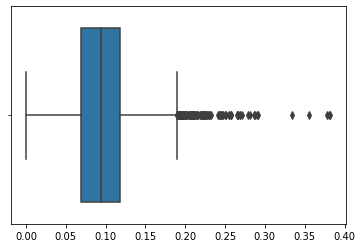

In [29]:
sns.boxplot(mutual_infos)
plt.show()

In [30]:
ds_test_Y1, info_test_Y1 = tfds.load(name='mlsst/Y1', split='test', with_info=True, as_supervised=True, batch_size=50)
ds_test_Y1 = ds_test_Y1.map(normalize)

In [31]:
softmax = []
accuracies = []
for _ in range(samples_iter):
  y = []
  yhat = []
  logits = []
  for (x_batch, y_batch) in ds_test_Y1:
      s = new_model.predict(x_batch)
      yhat.append(np.argmax(s, axis=-1))
      y.append(y_batch)
      logits.append(s)
  y = np.concatenate(y)
  yhat = np.concatenate(yhat)
  softmax.append(np.concatenate(logits))
  accuracies.append(np.mean(yhat == y))
  print('Accuracy:', np.mean(yhat == y))
softmax = np.array(softmax)

Accuracy: 0.5304542069992554
Accuracy: 0.5306031273268801
Accuracy: 0.5276247207743857
Accuracy: 0.5268801191362621
Accuracy: 0.5265822784810127
Accuracy: 0.5271779597915115
Accuracy: 0.5261355174981385
Accuracy: 0.5259865971705138
Accuracy: 0.5316455696202531
Accuracy: 0.5256887565152644
Accuracy: 0.5236038719285182
Accuracy: 0.526433358153388
Accuracy: 0.5255398361876397
Accuracy: 0.5335815338793746
Accuracy: 0.5300074460163813
Accuracy: 0.5240506329113924
Accuracy: 0.526433358153388
Accuracy: 0.5216679076693969
Accuracy: 0.5292628443782577
Accuracy: 0.5289650037230081
Accuracy: 0.5271779597915115
Accuracy: 0.5273268801191363
Accuracy: 0.5273268801191363
Accuracy: 0.529113924050633
Accuracy: 0.531198808637379
Accuracy: 0.5288160833953834
Accuracy: 0.5304542069992554
Accuracy: 0.5265822784810127
Accuracy: 0.5265822784810127
Accuracy: 0.5280714817572598
Accuracy: 0.5277736411020104
Accuracy: 0.5288160833953834
Accuracy: 0.5300074460163813
Accuracy: 0.5265822784810127
Accuracy: 0.527773

In [32]:
print('Accuracy', np.mean(accuracies), np.std(accuracies))

Accuracy 0.5287937453462398 0.003445623464021449


In [33]:
predictive_entropies = [] 
single_pass_entropies = []
mutual_infos = []
for i in range(softmax.shape[1]):
  predictive_entropy, single_pass_entropy, mutual_info = uncertainty(softmax[:,i,:])
  predictive_entropies.append(predictive_entropy)
  single_pass_entropies.append(single_pass_entropy)
  mutual_infos.append(mutual_info)
print('Predictive entropy:', np.mean(predictive_entropies), np.std(predictive_entropies))
print('Single pass entropy:', np.mean(single_pass_entropies), np.std(single_pass_entropies))
print('Mutual info:', np.mean(mutual_infos), np.std(mutual_infos))

Predictive entropy: 0.6539809428038921 0.3357729200996917
Single pass entropy: 0.5589484 0.32511187
Mutual info: 0.09503255430726877 0.04432828581332849


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


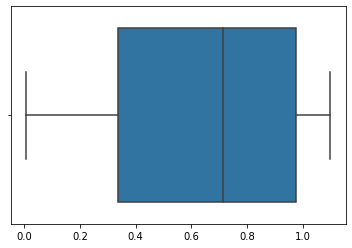

In [34]:
sns.boxplot(predictive_entropies)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


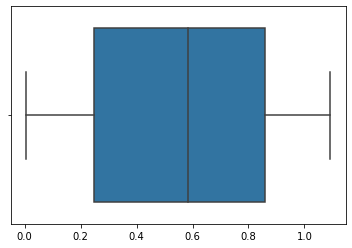

In [35]:
sns.boxplot(single_pass_entropies)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


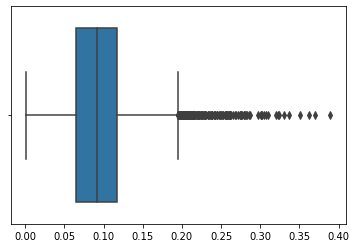

In [36]:
sns.boxplot(mutual_infos)
plt.show()